In [1]:
import os

import numpy as np
import itertools
from itertools import cycle
import pandas as pd

import umap

import matplotlib.pyplot as plt
from matplotlib import offsetbox
import matplotlib

import sklearn
from sklearn import manifold
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras import layers, metrics
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution2D, Conv1D, Deconvolution2D, MaxPooling1D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.text import *
from keras.utils import np_utils
from keras.models import model_from_json, load_model
from keras.regularizers import *
from keras.callbacks import CSVLogger
from keras import backend as K

from time import time
from time import localtime
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection)
from collections import Counter

ModuleNotFoundError: No module named 'umap'

In [2]:
os.environ['PYTHONHASHSEED'] = '0'

## The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
np.random.seed(42)

## Force TensorFlow to use single thread.
## Multiple threads are a potential source of
## non-reproducible results.
## For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=0, inter_op_parallelism_threads=0) #session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

## The below tf.set_random_seed() will make random number generation
## in the TensorFlow backend have a well-defined initial state.
## For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [4]:
# df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_w_dates_LM_5_0.dat", '\t')
df.head(10)

df = df[df['Country']!='VB']

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))
country_counts = df.groupby('Country').size()
print('{}'.format(country_counts))
country_counts = df.groupby('ColDay').size()
print('{}'.format(country_counts))
country_counts = df.groupby('MesDay').size()
print('{}'.format(country_counts))

X = df.iloc[:,8:-1]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]
y_country = df["Country"]
y_age_groups = df["AgeGroup"]
y_colday = df["ColDay"]
y_mesday = df["MesDay"]


print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))
print('shape of y country : {}'.format(y_country.shape))
print('shape of y colday : {}'.format(y_colday.shape))
print('shape of y mesday : {}'.format(y_mesday.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)
y_country = np.asarray(y_country)
y_age_groups = np.asarray(y_age_groups)
y_colday = np.asarray(y_colday)
y_mesday = np.asarray(y_mesday)

Species
AA    17251
AC     5995
AG    17481
dtype: int64
Status
BF     8611
GR     6737
SF    22102
UN     3277
dtype: int64
RearCnd
TF     9618
TL    27824
VF     3285
dtype: int64
Age
1     1596
2     1150
3     1530
4     2019
5     2323
6     2379
7     2630
8     2560
9     2796
10    2673
11    2704
12    2584
13    2816
14    2695
15    2869
16    2664
17    2739
dtype: int64
Country
B     8677
S     6430
T    25620
dtype: int64
ColDay
1465858800     17
1466463600     42
1466982000     23
1467068400     16
1467586800     15
1467673200      9
1468191600     28
1468278000     26
1468364400     44
1468882800     33
1468969200     39
1469055600     20
1469487600     77
1469574000     67
1471215600     87
1471388400     36
1473375600     38
1473634800     50
1473721200     17
1474758000     10
1474844400     79
1475103600     26
1475190000    138
1475362800     52
1475967600     27
1479427200     46
1479513600      8
1479772800     14
1479945600     31
1494630000     71
             

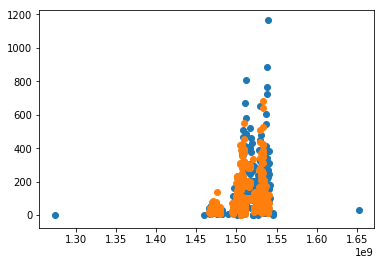

In [14]:
uniques, counts = np.unique(y_colday, return_counts=True)
uniques2, counts2 = np.unique(y_mesday, return_counts=True)
plt.scatter(uniques2, counts2)
plt.scatter(uniques, counts)


In [66]:
print(uniques[0])
print(localtime(uniques[0]))
# print(matplotlib.dates.num2date(uniques[0]))

1465858800
time.struct_time(tm_year=2016, tm_mon=6, tm_mday=14, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=1, tm_yday=166, tm_isdst=1)


In [83]:
# Scale and visualize the embedding vectors
def plot_embedding_Date_Old(X, y, Species=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        uniqueSpecies = np.unique(Species)
    
    ## Start plotting
    fig = plt.figure(figsize=(20,10))
    for i in range(len(uniqueSpecies)):
        ax = plt.subplot(1,len(uniqueSpecies),i+1)
        ## Get indicies of the species
        indicies = np.where(Species==uniqueSpecies[i])[0]
        plt.scatter(X[indicies, 0], X[indicies, 1], c=y[indicies], cmap=colorMap, s=5)         
        plt.xticks([]), plt.yticks([])
        plt.title(uniqueSpecies[i])
    plt.colorbar()    
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")


# Scale and visualize the embedding vectors
def plot_embedding_Date(X, y, Species=None, Country=None, saveDir=None, title=None, colorMap='Greys'):
    ## Sort the data
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    if Species is not None:
        if Country is not None:
            uniqueSpecies = np.unique(Species)
            uniqueCountries = np.unique(Country)
    
    ## Start plotting
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
    print(f'num of unique countries {len(uniqueCountries)}')
    print(f'num of unique countries {len(uniqueSpecies)}')
    count = 1
    for j in range(len(uniqueCountries)):
        for i in range(len(uniqueSpecies)):
            ax = plt.subplot(len(uniqueCountries),len(uniqueSpecies),count)
            ## Get indicies of the species
            indicies = np.where(np.logical_and(Species==uniqueSpecies[i], Country==uniqueCountries[j]))[0]
            if (len(y[indicies]==0)):
                print(f'Country : {uniqueCountries[j]} -- Species : {uniqueSpecies[i]}')
                print(f'min date : {localtime(np.min(y[indicies])).tm_year};{localtime(np.min(y[indicies])).tm_mon};{localtime(np.min(y[indicies])).tm_mday} -- max date : {localtime(np.max(y[indicies])).tm_year};{localtime(np.max(y[indicies])).tm_mon};{localtime(np.max(y[indicies])).tm_mday}') 
#             np.where(Species==uniqueSpecies[i])[0] and np.where(Country==uniqueCountries[j])[0]
            ax = plt.scatter(X[indicies, 0], X[indicies, 1], c=y[indicies], cmap=colorMap, s=5)         
            plt.xticks([]), plt.yticks([])
            plt.title(f'{uniqueSpecies[i]} - {uniqueCountries[j]}')
            plt.colorbar()  
            count += 1
#     fig.subplots_adjust(right=0.8)
#     cbar_ax = fig.add_axes([0.95, 0.10, 0.05, 0.8])
#     fig.colorbar(ax, cax=cbar_ax)    
    
    if title is not None:
        fig.suptitle(title)        

    plt.savefig(saveDir+title+".png")

Shape of X : (40727, 1625)
Computing UMAP projection
Embedding time: 954.3624827861786


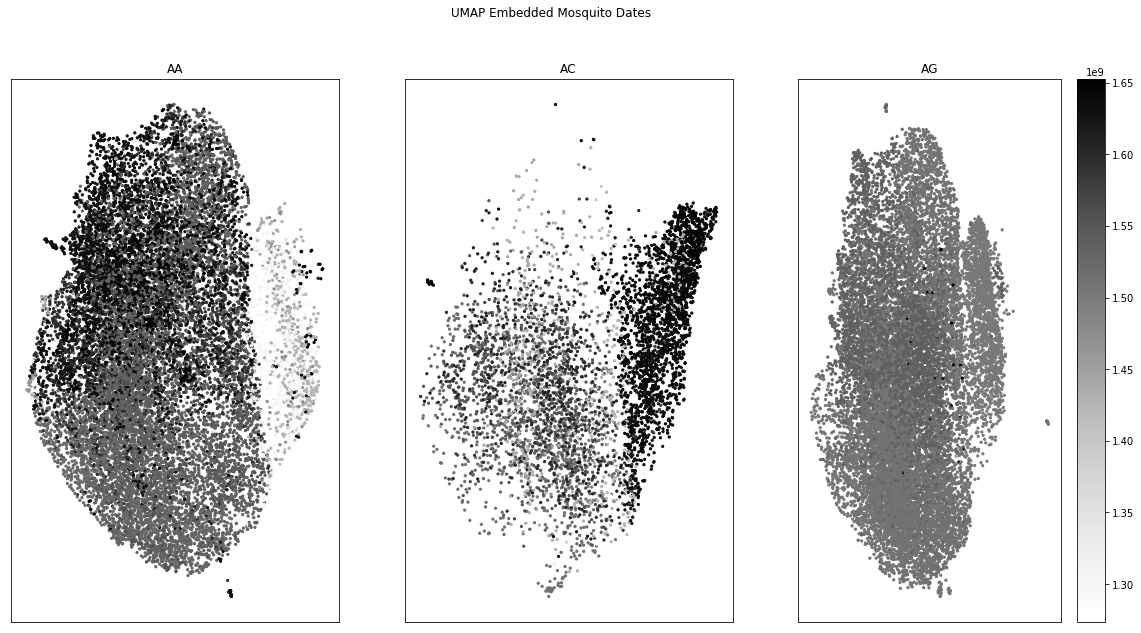

In [16]:
saveDir = '/home/josh/Documents/Mosquito_Project/MIMI-Analysis/Models/Dimension_Reduction/UMAP/outputs/UMAP_w_dates/'

## Scale features
X_scaled = StandardScaler().fit_transform(X=X)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
plot_embedding_Date(transformed, y_mesday, y_species, saveDir, ('UMAP Embedded Mosquito Dates'))


num of unique countries 3
num of unique countries 3
Country : B -- Species : AC
min date : 2017;12;12 -- max date : 2018;10;2
Country : B -- Species : AG
min date : 2010;5;8 -- max date : 2022;5;18
Country : S -- Species : AA
min date : 2016;6;6 -- max date : 2018;10;19
Country : S -- Species : AC
min date : 2018;8;31 -- max date : 2018;10;31
Country : S -- Species : AG
min date : 2017;7;12 -- max date : 2017;9;20
Country : T -- Species : AA
min date : 2018;1;9 -- max date : 2018;11;7
Country : T -- Species : AG
min date : 2017;9;21 -- max date : 2018;9;25


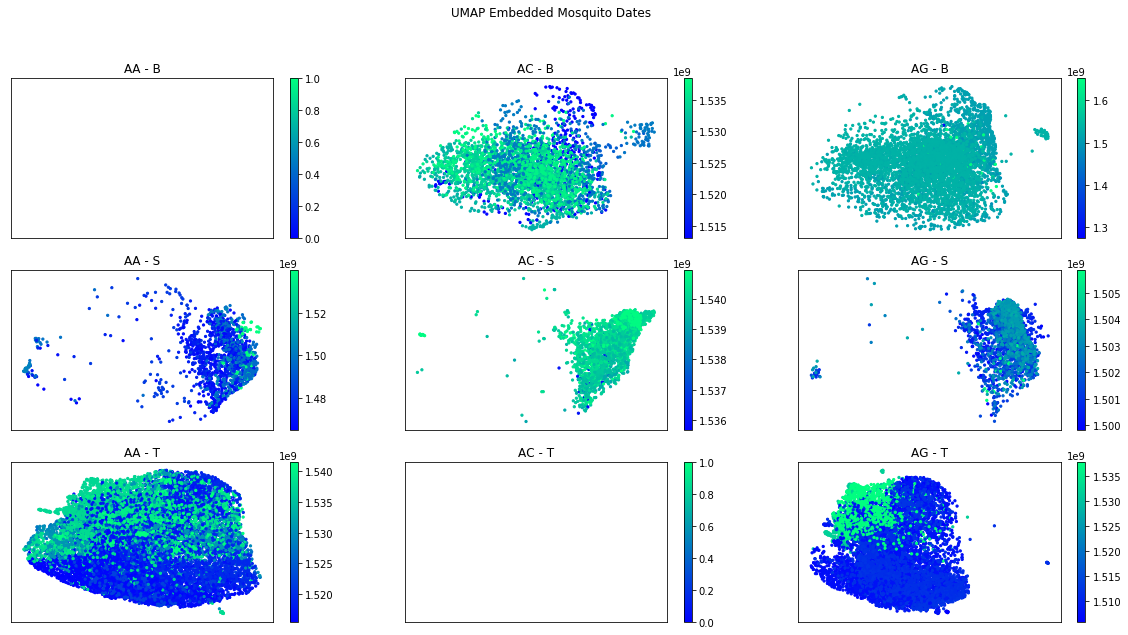

In [84]:
plot_embedding_Date(transformed, y_mesday, y_species, y_country, saveDir, ('UMAP Embedded Mosquito Dates'), colorMap='winter')


In [85]:
# df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata/mosquitos_country.dat", '\t')
df = pd.read_csv("/home/josh/Documents/Mosquito_Project/New_Data/Data/MIMIdata_update_19_02/mosquitoes_w_dates_LM_5_0.dat", '\t')
df.head(10)

df = df[df['Country']!='VB']
df = df[df['RearCnd']=='TL']

df['AgeGroup'] = 0
df['AgeGroup'] = np.where(df['Age']>10, 2, np.where(df['Age']>4, 1, 0))

Species_counts = df.groupby('Species').size()
print('{}'.format(Species_counts))
Status_counts = df.groupby('Status').size()
print('{}'.format(Status_counts))
RearCnd_counts = df.groupby('RearCnd').size()
print('{}'.format(RearCnd_counts))
age_counts = df.groupby('Age').size()
print('{}'.format(age_counts))
country_counts = df.groupby('Country').size()
print('{}'.format(country_counts))
country_counts = df.groupby('ColDay').size()
print('{}'.format(country_counts))
country_counts = df.groupby('MesDay').size()
print('{}'.format(country_counts))

X = df.iloc[:,8:-1]
y_age = df["Age"]
y_species = df["Species"]
y_status = df["Status"]
y_country = df["Country"]
y_age_groups = df["AgeGroup"]
y_colday = df["ColDay"]
y_mesday = df["MesDay"]


print('shape of X : {}'.format(X.shape))
print('shape of y age : {}'.format(y_age.shape))
print('shape of y species : {}'.format(y_species.shape))
print('shape of y status : {}'.format(y_status.shape))
print('shape of y country : {}'.format(y_country.shape))
print('shape of y colday : {}'.format(y_colday.shape))
print('shape of y mesday : {}'.format(y_mesday.shape))

X = np.asarray(X)
y_age = np.asarray(y_age)
y_species = np.asarray(y_species)
y_status = np.asarray(y_status)
y_country = np.asarray(y_country)
y_age_groups = np.asarray(y_age_groups)
y_colday = np.asarray(y_colday)
y_mesday = np.asarray(y_mesday)

Species
AA    10218
AC     4720
AG    12886
dtype: int64
Status
BF     5902
GR     5508
SF    16414
dtype: int64
RearCnd
TL    27824
dtype: int64
Age
1      881
2      762
3      990
4     1049
5     1524
6     1605
7     1723
8     1812
9     2094
10    1860
11    1955
12    1853
13    2005
14    1811
15    1922
16    1965
17    2013
dtype: int64
Country
B     4233
S     6430
T    17161
dtype: int64
ColDay
1465858800     17
1466463600     42
1466982000     23
1467068400     16
1467586800     15
1467673200      9
1468191600     28
1468278000     26
1468364400     44
1468882800     33
1468969200     39
1469055600     20
1469487600     77
1469574000     67
1471215600     87
1471388400     36
1473375600     38
1473634800     50
1473721200     17
1474758000     10
1474844400     79
1475103600     26
1475190000    138
1475362800     52
1475967600     27
1479427200     46
1479513600      8
1479772800     14
1479945600     31
1494630000     71
             ... 
1531436400     39
1531609200   

Shape of X : (27824, 1625)
Computing UMAP projection
Embedding time: 571.4561471939087
num of unique countries 3
num of unique countries 3
Country : B -- Species : AC
min date : 2018;3;12 -- max date : 2018;9;18
Country : B -- Species : AG
min date : 2018;7;6 -- max date : 2018;12;20
Country : S -- Species : AA
min date : 2016;6;6 -- max date : 2018;10;19
Country : S -- Species : AC
min date : 2018;8;31 -- max date : 2018;10;31
Country : S -- Species : AG
min date : 2017;7;12 -- max date : 2017;9;20
Country : T -- Species : AA
min date : 2018;1;9 -- max date : 2018;3;28
Country : T -- Species : AG
min date : 2017;9;21 -- max date : 2017;12;5


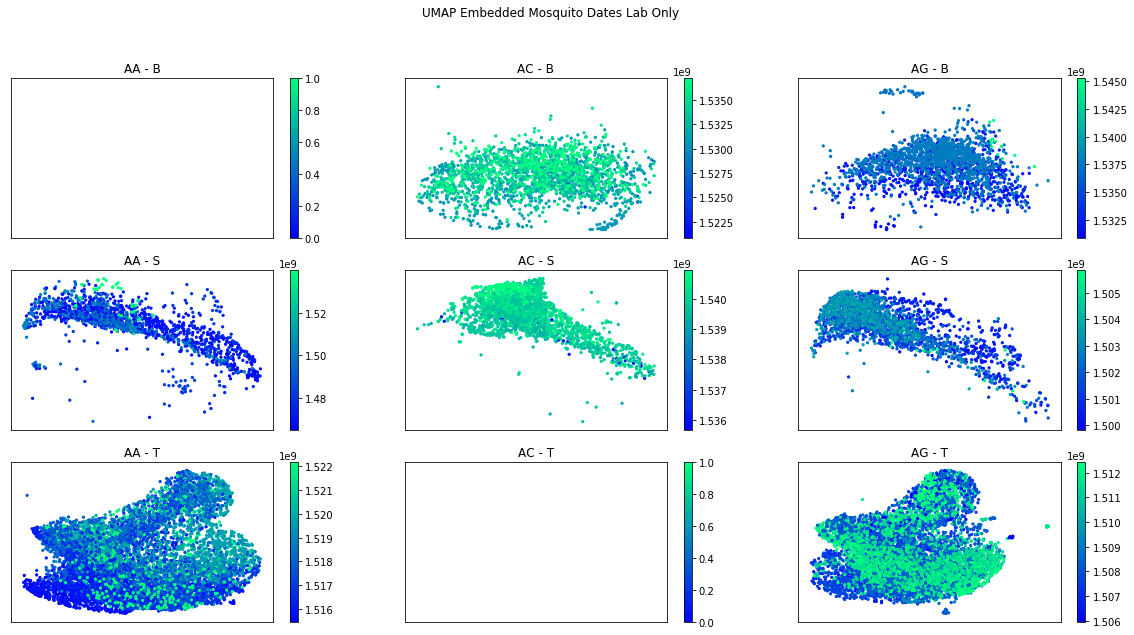

In [86]:
saveDir = '/home/josh/Documents/Mosquito_Project/MIMI-Analysis/Models/Dimension_Reduction/UMAP/outputs/UMAP_w_dates/'

## Scale features
X_scaled = StandardScaler().fit_transform(X=X)

# for num_neighbours, num_metric in ([[3,'chebyshev'],[4,'chebyshev'],[4,'correlation'],[5,'braycurtis'],[5,'correlation'],[6,'canberra']]):
#     for num_min_dist in [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]:
num_neighbours = 32
num_min_dist = 0.7
num_metric = 'chebyshev'
## PCA embedding of the digits dataset
dimensions = 2
print('Shape of X : {}'.format(X.shape))
print("Computing UMAP projection")
t0 = time()
#reducer = umap.UMAP(random_state=42, n_components=dimensions)
reducer = umap.UMAP(random_state=42, n_components=dimensions, n_neighbors=num_neighbours, metric=num_metric, min_dist=num_min_dist)
embedding = reducer.fit(X_scaled)
transformed = reducer.transform(X_scaled)
print('Embedding time: {}'.format(time()-t0))

## Call plotting function
plot_embedding_Date(transformed, y_mesday, y_species, y_country, saveDir, ('UMAP Embedded Mosquito Dates Lab Only'), colorMap='winter')
